In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import numpy as np
import pandas as pd
import h5py
import itertools
import python_utils_jjm as utils_jjm
from tqdm import tqdm
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/')
import miniscope_analysis as ma 
import scipy.spatial.distance as dist
import sklearn.metrics as skm
from tqdm import tqdm

In [4]:
reload(ma)
reload(utils_jjm)

<module 'python_utils_jjm' from '/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/python_utils_jjm.py'>

In [6]:
dir_ = '/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/'

In [7]:
velocity_aligned = pd.read_hdf(dir_+'all_mice_aligned_to_behavior.h5')

In [15]:
wt_mice = ['GRIN027', 'GRIN026', 'GRIN013']
ko_mice = ['GRIN012', 'GRIN018', 'GRIN011']

In [16]:
velocity_aligned.head()

GRIN027                                                            \
  behavior                                                             
  frameNum camNum sysClock buffer behavCam_frames sys_clock_behavCam   
0        1      0        0      1               1                  0   
1        2      0       39      1               2                 26   
2        3      0       89      1               4                 91   
3        4      0      139      1               5                123   
4        5      0      189      1               7                187   

                                                      ...    GRIN011  \
                                                      ... C_z_scored   
  Unnamed: 0            File           X           Y  ...        110   
0          0  behavCam01.avi  374.310798  186.554970  ...  -0.910805   
1          1  behavCam01.avi  372.048011  188.167240  ...  -0.910805   
2          2  behavCam01.avi  369.392349  190.981512  ...  -0.910805   
3          3  behavCam01.avi  367.451050  193.573317  ...  -0.910805   
4          4  behavCam01.avi  364.920711  196.173484  ...  -0.910805   

                                                                         \
                                                                          
        111       112       113       114       115       116       117   
0 -0.716258 -1.003124 -1.671407 -0.038928 -0.093372 -0.388336 -0.576353   
1 -0.716258 -1.015537 -1.671407  0.591083  0.196577 -0.418647 -0.601489   
2 -0.716258 -1.026868 -1.671407  0.477424  0.081509 -0.447924 -0.625486   
3 -0.716258 -1.037211 -1.671407  0.373363  0.428509 -0.476204 -0.648395   
4 -0.716258 -1.046652 -1.671407  0.278089  0.285534 -0.503520 -0.670265   

                       
                       
        118       119  
0 -0.959844 -0.809900  
1 -0.959844 -0.832530  
2 -0.959844 -0.853981  
3 -0.959844 -0.874314  
4 -0.959844 -0.893588  

[5 rows x 463 columns]

In [19]:
## velocity correlations by genotype 
wt_cell_z_v_linear_r = []
#mouse = 'GRIN026'
for mouse in wt_mice:
    for cell in velocity_aligned[mouse]['C_z_scored']:
        wt_cell_z_v_linear_r.append(stats.pearsonr(velocity_aligned[mouse]['C_z_scored'][cell], velocity_aligned[mouse]['behavior']['velocity'])[0])
        
ko_cell_z_v_linear_r = []
#mouse = 'GRIN026'
for mouse in ko_mice:
    for cell in velocity_aligned[mouse]['C_z_scored']:
        ko_cell_z_v_linear_r.append(stats.pearsonr(velocity_aligned[mouse]['C_z_scored'][cell], velocity_aligned[mouse]['behavior']['velocity'])[0])


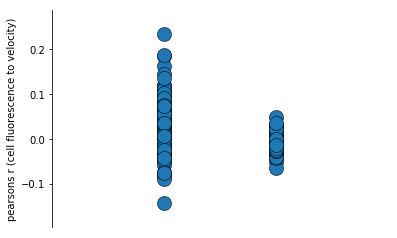

In [43]:
plt.scatter(np.concatenate([np.zeros(len(wt_cell_z_v_linear_r)),np.ones(len(ko_cell_z_v_linear_r))/2]), np.concatenate([wt_cell_z_v_linear_r, ko_cell_z_v_linear_r]),
           s=200, linewidths=.5, edgecolors='k')
plt.xlim([-.5, 1])
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
plt.xticks([])
plt.ylabel('pearsons r (cell fluorescence to velocity)')
plt.draw()
plt.savefig('/Users/johnmarshall/Documents/Presentations/Dec2019_report/cell_velocity_correlation.png')
plt.savefig('/Users/johnmarshall/Documents/Presentations/Dec2019_report/cell_velocity_correlation.svg', transparent=True, format="svg")

In [45]:
velocity_aligned[mouse]['C_z_scored'].shape[1]

(25000, 120)

In [99]:
## ISI intervals by genotype 
wt_ISIs = []
ko_ISIs = []
#mouse = 'GRIN026'
#velocity_aligned[mouse]['C_z_scored']:
for mouse in wt_mice:      
    wt_ISIs.append(np.hstack(utils_jjm.get_ISIs(velocity_aligned[mouse]['C_z_scored'], 20, velocity_aligned[mouse]['C_z_scored'].shape[1], 2)[1]))
for mouse in ko_mice:      
    ko_ISIs.append(np.hstack(utils_jjm.get_ISIs(velocity_aligned[mouse]['C_z_scored'], 20, velocity_aligned[mouse]['C_z_scored'].shape[1], 2)[1]))


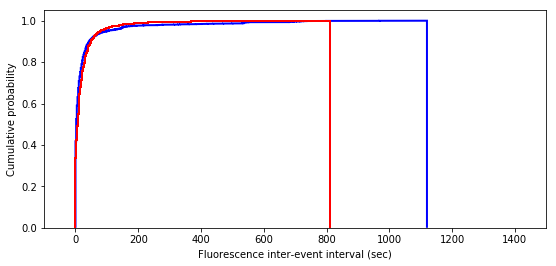

In [100]:
##plotting overall distribution of ISIs
fig, ax = plt.subplots(figsize=(9, 4))
n, bins, patches = ax.hist(np.hstack(wt_ISIs), bins='auto', density=True, histtype='step', cumulative=True, label='Empirical', linewidth=2, color='b')
n, bins, patches = ax.hist(np.hstack(ko_ISIs), bins='auto', density=True, histtype='step', cumulative=True, label='Empirical', linewidth=2, color='r')
plt.ylabel('Cumulative probability')
plt.xlabel('Fluorescence inter-event interval (sec)')
plt.xlim(-100, 1500)
plt.draw()

In [168]:
#for resting periods find all 1 second regions where mouse is moving, then resting periods are seconds where there is no velocity bin 
binned_v_for_resting = utils_jjm.binning_function_uncrop(100, velocity_aligned[mouse]['behavior']['velocity'], 0.05)
#for moving periods find all 100 msecond regions where mouse is moving, then resting periods are seconds where there is no velocity bin 
binned_v_for_moving = utils_jjm.binning_function_uncrop(5, velocity_aligned[mouse]['behavior']['velocity_z_score'], 3)

In [169]:
binned_c_zscore = utils_jjm.binning_function_uncrop(50, velocity_aligned[mouse]['behavior']['velocity'], .1)

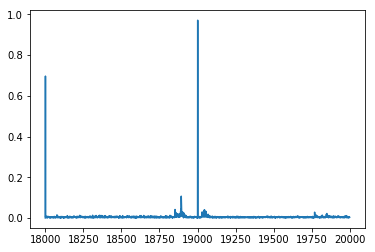

In [170]:
plt.plot(velocity_aligned[mouse]['behavior']['velocity'][18000:20000])

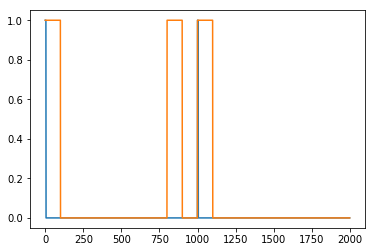

In [171]:
plt.plot(binned_v_for_moving[18000:20000])
plt.plot(binned_v_for_resting[18000:20000])
plt.show()

In [172]:
moving = np.argwhere(binned_v_for_moving == 1 )
not_moving = np.argwhere(binned_v_for_resting == 0)
moving_indicies = np.array([moving[x][0] for x in range(np.shape(moving)[0])])
resting_indicies = np.array([not_moving[x][0] for x in range(np.shape(not_moving)[0])])

In [173]:
velocity_aligned.iloc[moving_indicies,:]['GRIN026']['behavior']['velocity'].head()

150    0.006341
151    0.005396
152    0.005684
153    0.000718
154    0.003429
Name: velocity, dtype: float64

In [174]:
velocity_aligned.iloc[resting_indicies,:]['GRIN026']['behavior']['velocity'].head()

2000    0.000000
2001    0.014966
2002    0.010718
2003    0.008852
2004    0.005900
Name: velocity, dtype: float64

In [183]:
np.max(velocity_aligned.iloc[moving_indicies,:]['GRIN026']['behavior']['velocity'])

0.02925725987289832

In [184]:
np.max(velocity_aligned.iloc[resting_indicies,:]['GRIN026']['behavior']['velocity'])

0.22064730277058348

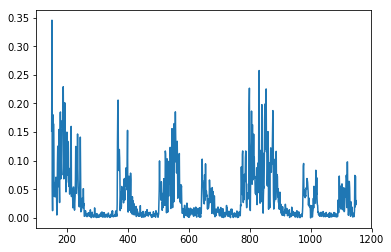

In [185]:
plt.plot(velocity_aligned[mouse]['behavior']['velocity'][150:1150])

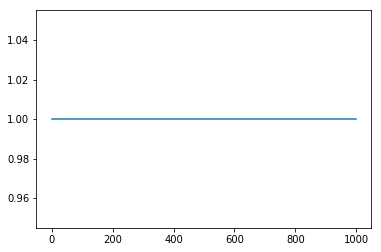

In [186]:
plt.plot(binned_v_for_resting[150:1150])